# Fine-tuning Transformers for Text Generation

In this notebook we'll take a look at fine-tuning a famous Transformer model called [GPT-2](https://huggingface.co/gpt-2) to generate text in the style of Shakespeare. By the end of this notebook you should know how to:

* Load and process a dataset from the Hugging Face Hub
* Fine-tune a pretrained model on your data
* Push a model to the Hugging Face Hub

Let's get started!

## Setup

If you're running this notebook on Google Colab or locally, you'll need a few dependencies installed. You can install them with `pip` as follows:

In [ ]:
#! pip install datasets transformers sentencepiece

To be able to share your model with the community there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS. Uncomment and execute the following cell:

In [ ]:
# !apt install git-lfs

## The dataset

In this notebook we'll be using 🤗 Datasets to load and preprocess our data. If you're new to this library, check out the video below to get some additional context:

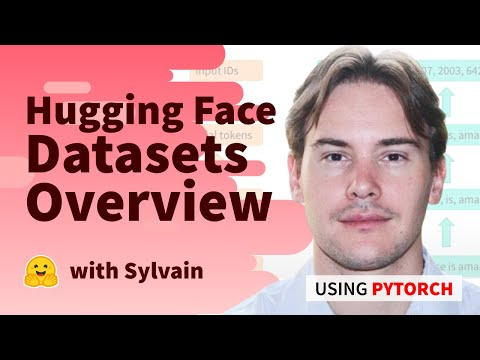

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

In this tutorial we'll use the [`tiny_shakespeare`](https://huggingface.co/datasets/tiny_shakespeare) dataset which contains around 40,000 lines of Shakespeare from a variety of his plays. This dataset was featured in Andrej Karpathy's famous blog post [_The Unreasonable Effectiveness of Recurrent Neural Networks_](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), so go check it out if you haven't read it before!

Let's begin by downloading the data with the `load_dataset()` function from 🤗 Datasets:

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("tiny_shakespeare")
raw_datasets

Using custom data configuration default
Found cached dataset tiny_shakespeare (/home/lewis/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

One cool feature of 🤗 Datasets is that `load_dataset()` will cache the files at` ~/.cache/huggingface/dataset/`, so you won't need to re-download the dataset the next time your run the notebook.

We can see that `raw_datasets` is a DatasetDict object which is similar to a Python dictionary, with each key corresponding to a different split.

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called tokenization. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors.

For more information about tokenizers, check out the following video:

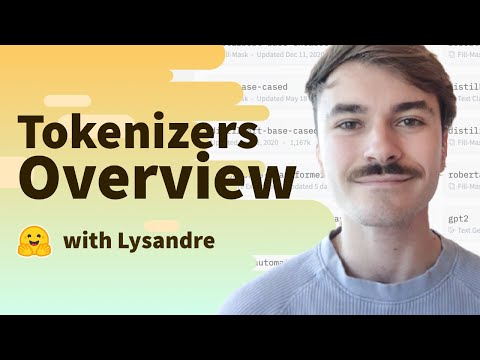

In [3]:
YouTubeVideo("VFp38yj8h3A", width=600, height=400)

Each pretrained model comes with its own tokenizer, so to get started let's download the tokenizer of DistilGPT-2 from the Hub:

In [3]:
from transformers import AutoTokenizer

model_checkpoint = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

The tokenizer has a few interesting attributes such as the vocabulary size:

In [4]:
tokenizer.vocab_size

50257

This tells us that DistilGPT-2 has 50,257 tokens that is can use to represent text with. Some of the tokens are called _special tokens_ to indicate whether a token is the start or end of a sentence, or corresponds to the mask that is associated with language modeling. Here's what the special tokens look like for DistilGPT-2:

In [5]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [6]:
encoded_str = tokenizer("Today I'm giving an NLP workshop at HSLU")
encoded_str

{'input_ids': [8888, 314, 1101, 3501, 281, 399, 19930, 20243, 379, 367, 8634, 52], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

and then decode the input IDs to see the mapping explicitly:

In [7]:
for token in encoded_str["input_ids"]:
    print(token, tokenizer.decode([token]))

2022-10-05 16:18:21.561094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 16:18:21.675532: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 16:18:22.033569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-10.2/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda-10.0/lib64:$LD_LIBRARY_PATH
2022-10-05 16:18:22.033616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] 

8888 Today
314  I
1101 'm
3501  giving
281  an
399  N
19930 LP
20243  workshop
379  at
367  H
8634 SL
52 U


So to prepare our inputs, we simply need to apply the tokenizer to each example in our corpus. As before, we'll do this with `Dataset.map()` so let's write a simple function to do so:

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_datasets

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e/cache-44ec4c797793c324.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e/cache-51a64f5f3b237ba3.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (17995 > 1024). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1
    })
})

Now for the harder part: We need to concatenate all our texts together, and then split the result into chunks of a fixed size, which we will call `block_size`. To do this, we will use the map method again, with the option batched=True. When we use batched=True, the function we pass to `map()` will be passed multiple inputs at once, allowing us to group them into more or fewer examples than we had in the input. This allows us to create our new fixed-length samples.

We can use any block_size up to the the maximum length our model was pretrained with, which for models in the gpt2 family is usually something in the range 512-1024. This might be a bit too big to fit in your GPU RAM, though, so let's use something a bit smaller: 128.

In [9]:
# get block size (max input length of the model)
block_size = 128
    
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

# split total dataset into smaller sets of length block_size
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True
)
lm_datasets

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e/cache-a0a25c5b41f427da.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e/cache-2cbd5e943dcef0c1.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2359
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 141
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})

And we can check our datasets have changed: now the samples contain chunks of block_size contiguous tokens, potentially spanning several of our original texts:

In [10]:
print(tokenizer.decode(lm_datasets["train"][1]["input_ids"]))

 done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our p


This looks good, so now let's load a pretrained model!

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `AutoModelForXxx` class and use the `from_pretrained()` function with the model checkpoint. In our case, we're dealing with 5 classes (one for each star) so to initialise the model we'll provide this information along with the label mappings:

In [11]:
from transformers import TFAutoModelForCausalLM

model = TFAutoModelForCausalLM.from_pretrained(model_checkpoint)

2022-10-05 16:18:28.642426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:18:28.642673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:18:28.643064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:18:28.643266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:18:28.643460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Once we've done that, it's time for our optimizer! We can initialize our `AdamWeightDecay` optimizer directly, or we can use the `create_optimizer` function to generate an `AdamWeightDecay` optimizer with a learning rate schedule. In this case, we'll just stick with a constant learning rate for simplicity, so let's just use `AdamWeightDecay`:

In [12]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(lr=2e-5, weight_decay_rate=0.01)

/home/lewis/miniconda3/envs/hf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Next, we compile our model. Note that most Transformers models compute loss internally, so we actually don't have to specify anything for that argument! You can of course set your own loss function if you want, but by default our models will choose the 'obvious' loss that matches their task, such as cross-entropy in the case of language modelling. The built-in loss will also correctly handle things like masking the loss on padding tokens, or unlabelled tokens in the case of masked language modelling, so we recommend using it unless you're an advanced user!

In [14]:
import tensorflow as tf

model.compile(optimizer=optimizer, jit_compile=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Next, we convert our datasets to `tf.data.Dataset`, which Keras understands natively. There are two ways to do this - we can use the slightly more low-level `Dataset.to_tf_dataset()` method, or we can use `Model.prepare_tf_dataset()`. The main difference between these two is that the Model method can inspect the model to determine which column names it can use as input, which means you don't need to specify them yourself. It also supplies a data collator by default which is appropriate for most tasks:

In [15]:
train_set = model.prepare_tf_dataset(
    lm_datasets["train"],
    shuffle=True,
    batch_size=16,
)

validation_set = model.prepare_tf_dataset(
    lm_datasets["validation"],
    shuffle=False,
    batch_size=16,
)

Now we can train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! If you don't want to do this, simply remove the callbacks argument in the call to `fit()`:

In [16]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [17]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-shakespeare"

tensorboard_callback = TensorBoard(log_dir="./clm_model_save/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir="./clm_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

callbacks = [tensorboard_callback, push_to_hub_callback]

model.fit(train_set, validation_data=validation_set, epochs=20, callbacks=callbacks)

Cloning https://huggingface.co/lewtun/distilgpt2-finetuned-shakespeare into local empty directory.


Download file tf_model.h5:   0%|          | 7.52k/313M [00:00<?, ?B/s]

Download file logs/validation/events.out.tfevents.1664986230.brutasse.17269.1.v2: 100%|##########| 1.56k/1.56k…

Download file logs/validation/events.out.tfevents.1664985154.brutasse.13704.1.v2: 100%|##########| 1.56k/1.56k…

Clean file logs/validation/events.out.tfevents.1664986230.brutasse.17269.1.v2:  64%|######4   | 1.00k/1.56k [0…

Download file logs/train/events.out.tfevents.1664985123.brutasse.13704.0.v2:   4%|3         | 32.0k/871k [00:0…

Clean file logs/validation/events.out.tfevents.1664985154.brutasse.13704.1.v2:  64%|######4   | 1.00k/1.56k [0…

Download file logs/train/events.out.tfevents.1664986200.brutasse.17269.0.v2:   1%|          | 8.00k/871k [00:0…

Clean file logs/train/events.out.tfevents.1664985123.brutasse.13704.0.v2:   0%|          | 1.00k/871k [00:00<?…

Clean file logs/train/events.out.tfevents.1664986200.brutasse.17269.0.v2:   0%|          | 1.00k/871k [00:00<?…

Clean file tf_model.h5:   0%|          | 1.00k/313M [00:00<?, ?B/s]

Epoch 1/20


2022-10-05 16:21:00.143098: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x561cb0c56180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-05 16:21:00.143146: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2022-10-05 16:21:00.143153: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA TITAN RTX, Compute Capability 7.5
2022-10-05 16:21:00.271787: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-10-05 16:21:00.283763: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. tfgpt2lm_head_model/transformer/dropout/dropout/random_uniform/RandomUniform
2022-

147/147 [==============================] - ETA: 0s - loss: 4.2106

2022-10-05 16:21:26.361623: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator tfgpt2lm_head_model/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2022-10-05 16:21:28.152071: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator tfgpt2lm_head_model/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


147/147 [==============================] - 56s 266ms/step - loss: 4.2106 - val_loss: 3.8274
Epoch 2/20
147/147 [==============================] - 14s 94ms/step - loss: 3.9005 - val_loss: 3.6991
Epoch 3/20
147/147 [==============================] - 14s 94ms/step - loss: 3.7791 - val_loss: 3.6211
Epoch 4/20
147/147 [==============================] - 14s 94ms/step - loss: 3.7051 - val_loss: 3.5864
Epoch 5/20
147/147 [==============================] - 14s 95ms/step - loss: 3.6473 - val_loss: 3.5637
Epoch 6/20
147/147 [==============================] - 36s 247ms/step - loss: 3.6008 - val_loss: 3.5437
Epoch 7/20
147/147 [==============================] - 14s 95ms/step - loss: 3.5575 - val_loss: 3.5355
Epoch 8/20
147/147 [==============================] - 14s 95ms/step - loss: 3.5203 - val_loss: 3.5273
Epoch 9/20
147/147 [==============================] - 14s 95ms/step - loss: 3.4836 - val_loss: 3.5186
Epoch 10/20
147/147 [==============================] - 14s 95ms/step - loss: 3.4517 - val_l

## Using your fine-tuned model

Now we've trained our model, let's see how we could load it and use it to generate text in future! First, let's load it from the hub. This means we can resume the code from here without needing to rerun everything above every time:

In [ ]:
from transformers import pipeline

text_generator = pipeline("text-generation", model=f"lewtun/{push_to_hub_model_id}", device=0, framework="tf")

outputs = text_generator("HAMLET: Behold, I am ")[0]
print(outputs["generated_text"])

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

## Your turn!

Use the code in this notebook to fine-tune GPT-2 on a new dataset of your choice from the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:text-generation&sort=downloads). If you want to be creative, you can create your own dataset and upload it to the Hub easily with a few clicks - check out the docs [here](https://huggingface.co/docs/datasets/upload_dataset).

**Tips**

* If you have time and a good GPU, you can try fine-tuning a larger GPT model like the original [`gpt2`](https://huggingface.co/gpt2) or [GPT-Neo](https://huggingface.co/EleutherAI/gpt-neo-2.7B). This will usually produce better text generations, at the expense of needing more GPU memory.